### This project attempts to classify SBA Loan's using Random Forest Classification and MLPClassifier
Below are the necessary imports I will be using.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sba-loans-case-data-set/SBAcase.11.13.17.csv


### Reading and Cleaning data for Feature Selection
The data set is read into a dataframe using pandas. All non-numeric features are removed. ChgOffDate mostly consistes of NA and BalanceGross is all zeros, so both are removed. The features are placed extracted to X and default dummy variables to y. The total dataset loan default rate is printed below. The feature set is then standarized and normalized.
<br />
TODO: encode and add non-numeric features. Handle NA values. 

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler1 = MinMaxScaler()


df = pd.read_csv("../input/sba-loans-case-data-set/SBAcase.11.13.17.csv")

df = df.select_dtypes(exclude = 'object')
#removes 'ChgOffDate' and 'BalanceGross' features
df = df.loc[:, df.columns != 'ChgOffDate']
df = df.loc[:, df.columns != 'BalanceGross']
df = df.loc[:, df.columns != 'Zip']
#remove remaining NA values
df = df.dropna()
df.info()
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,0:df.shape[1]-1], df.iloc[:,df.shape[1]-1], test_size = .2, random_state = 1)
x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

print('Loan Default percentage in dataset: %.1f%%' % (100*np.mean(y_train)))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2098 entries, 0 to 2100
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Selected           2098 non-null   int64  
 1   LoanNr_ChkDgt      2098 non-null   int64  
 2   NAICS              2098 non-null   int64  
 3   ApprovalDate       2098 non-null   int64  
 4   ApprovalFY         2098 non-null   int64  
 5   Term               2098 non-null   int64  
 6   NoEmp              2098 non-null   int64  
 7   NewExist           2098 non-null   float64
 8   CreateJob          2098 non-null   int64  
 9   RetainedJob        2098 non-null   int64  
 10  FranchiseCode      2098 non-null   int64  
 11  UrbanRural         2098 non-null   int64  
 12  DisbursementDate   2098 non-null   float64
 13  DisbursementGross  2098 non-null   int64  
 14  ChgOffPrinGr       2098 non-null   int64  
 15  GrAppv             2098 non-null   int64  
 16  SBA_Appv           2098 

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler1 = MinMaxScaler()


df = pd.read_csv("../input/sba-loans-case-data-set/SBAcase.11.13.17.csv")

df = df.select_dtypes(exclude = 'object')
#removes 'ChgOffDate' and 'BalanceGross' features
df = df.loc[:, df.columns != 'ChgOffDate']
df = df.loc[:, df.columns != 'BalanceGross']
df = df.loc[:, df.columns != 'Zip']
#remove remaining NA values
df = df.dropna()
default = 0
pif = 0
for i, v in df.items():
    if i == "Default":
        for k in v:
            if k == 0:
                pif += 1
            else:
                default += 1

print("Data amount", df.shape)
print("Default: ", default, "PIF: ", pif)

Data amount (2098, 24)
Default:  686 PIF:  1412


### Feature Selection using ExtraTreesClassifier
The Extremely Randomized Trees Classifier was used for feature selection. This model uses ensembled decision trees (in this case 100) to calculate the Gini impurity of each feature. This is unncessary, with not a lot of features all of them can be used. In this case, my impurity condition keeps all features.
<br />
The feature impurity is graphed below.

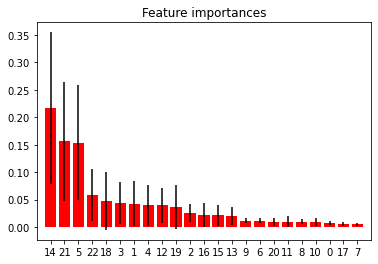

In [6]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(random_state=1)

forest.fit(x_train, y_train)

# feat_importances = pd.Series(forest.feature_importances_, index=x_train.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# # lists to store feature indices and impurity value are created
# feature_indices = []
# feature_importance = []

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
#     feature_indices.append(indices[f])
#     feature_importance.append(importances[indices[f]])
# feature_importance_array = np.array(list(zip(feature_indices,feature_importance)))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

# mean = feature_importance_array.mean(axis=0)[1]

# best_features = feature_importance_array[(feature_importance_array >= 0.00).all(axis=1)]


### The selected features are chosen from dataframe
The features chosen above (in this case all of them), are extracted from the features dataframe (X) and converted to an array for modeling (X1). 


In [2]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler


# scaler = StandardScaler()
# scaler1 = MinMaxScaler()



# feat_list = []
# for i in range(0, best_features.shape[0]):
#     feat_list.append(int(best_features[i,0]))


# important_features_df = df.iloc[:,feat_list]

# new_X = important_features_df.iloc[:,0:best_features.shape[0]]
# new_X = new_X.astype(float)

# new_X2 = scaler.fit_transform(new_X)
# new_X3 = scaler1.fit_transform(new_X2)

# X1 = np.array(new_X3)

# print(X1.shape)

### RandomForestClassifier model is trained and tested, Low Accuracy
The data was split into training and test sets. 10 fold cross validation was used to ensure genrality in the model. I experimented with better accuracy measures than model.predict, and included a confusion matrix. I am still having trouble with this model being too accurate and I'm not sure why. 


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, log_loss, f1_score
from sklearn.dummy import DummyClassifier
import seaborn as sns

dummy_model = DummyClassifier(strategy = "most_frequent", random_state = 1)
model = RandomForestClassifier(random_state = 1)
# Model optimized from RandomSearchcv (below), no better than default:
# model = RandomForestClassifier(max_depth=43, max_features='log2', min_samples_split=152, n_estimators=162, random_state=1)


# evaluate the model
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1)
n_scores = cross_val_score(model, x_train, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1, error_score='balanced_accuracy')
print('Training set k-fold cross validation accuracy: %.3f%% (%.3f)' % (100*np.mean(n_scores), np.std(n_scores)))

# report performance
dummy_model.fit(x_train,y_train)
dummy_acc = dummy_model.score(x_test,y_test)*100
dumb_pred = dummy_model.predict(x_test)
print('Dummy model accuracy: %.3f%%' % dummy_acc)

model.fit(x_train,y_train)

#basic predict
y_pred = model.predict(x_test)
pred_accuracy_percentage = 100 * accuracy_score(y_test,y_pred)
print('Test set accuracy: %.3f%%' % pred_accuracy_percentage)

#ROC AUC metric
pred_auc = model.predict_proba(x_test)[:,1]
acc = roc_auc_score(y_test, pred_auc)
print('AUC: %.3f%%' % (100*acc))

#log loss metric
lloss = log_loss(y_test,pred_auc, normalize = True)
print('Log loss: %.3f' % lloss)

#f1_score
f1 = f1_score(y_test,y_pred)
print('F1 Score: %.3f' % f1)

#Confusion Matrix
plt.figure()
ax = plt.axes()
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax)
ax.set_title('Confusion Matrix of Loan Default Classifier')
plt.show()




### RandomizedSearch RandomForest, n_estimators, max_features, max_depth, min_samples_split
This doesn't help much. Needs more work or RandomForest may not be a good method.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

forest = RandomForestClassifier(random_state = 1)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 199)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2',None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 200, num = 199)]
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 200, num = 199)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

# pprint(random_grid)

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=1, n_jobs = -1, scoring='balanced_accuracy', return_train_score=True)
# Fit the random search model
rf_random.fit(x_train, y_train)

cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2['mean_test_score'], cvres2["params"]):
    print(np.sqrt(mean_score), params)
    
print("best estimator")
print(rf_random.best_estimator_)

print("best params")
print(rf_random.best_params_)
print("best estimator")
print(rf_random.best_estimator_)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, log_loss, f1_score
from sklearn.dummy import DummyClassifier
import seaborn as sns

dummy_model = DummyClassifier(strategy = "most_frequent", random_state = 1)
model = RandomForestClassifier(random_state = 1)
# Model optimized from RandomSearchcv (below), no better accuracy than default:
#model = RandomForestClassifier(max_depth=43, max_features='log2', min_samples_split=152, n_estimators=162, random_state=1)


# evaluate the model
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1)
n_scores = cross_val_score(model, x_train, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=-1, error_score='balanced_accuracy')
print('Training set k-fold cross validation accuracy: %.3f%% (%.3f)' % (100*np.mean(n_scores), np.std(n_scores)))

# report performance
dummy_model.fit(x_train,y_train)
dummy_acc = dummy_model.score(x_test,y_test)*100
dumb_pred = dummy_model.predict(x_test)
print('Dummy model accuracy: %.3f%%' % dummy_acc)

model.fit(x_train,y_train)

#basic predict
y_pred = model.predict(x_test)
pred_accuracy_percentage = 100 * accuracy_score(y_test,y_pred)
print('Test set accuracy: %.3f%%' % pred_accuracy_percentage)

#ROC AUC metric
pred_auc = model.predict_proba(x_test)[:,1]
acc = roc_auc_score(y_test, pred_auc)
print('AUC: %.3f%%' % (100*acc))

#log loss metric
lloss = log_loss(y_test,pred_auc, normalize = True)
print('Log loss: %.3f' % lloss)

#f1_score
f1 = f1_score(y_test,y_pred)
print('F1 Score: %.3f' % f1)

#Confusion Matrix
plt.figure()
ax = plt.axes()
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax)
ax.set_title('Confusion Matrix of Loan Default Classifier')
plt.show()





### Simple MLPClassifier
I have finally got a nerual network training on this data accurately! Standardizing and normalizing the features drastically increased my accuracy. This model needs more work, I am excited to keep playing with this an incorporate HyperOpt tuning, graphing, and more.

### Sequential ANN, accuracies and epochs graphed with validation set, basic regularization added

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import BinaryCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, log_loss, f1_score
from keras.regularizers import l2

x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = 1)
l = l2(0.003)


def getModel():
    den = Dense(15, kernel_regularizer=l, bias_regularizer=l,kernel_initializer='glorot_uniform', activation='relu')
    model = Sequential()
    model.add(Dense(15, kernel_regularizer=l, bias_regularizer=l,input_dim=23, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(den)
    model.add(den)
    model.add(Dense(1, kernel_regularizer=l, bias_regularizer=l,kernel_initializer='glorot_uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model


model = getModel()
history = model.fit(x_train_, y_train_, validation_data=(x_val, y_val), epochs=1000, verbose=0)
# plot history
# summarize history for accuracy
plt.figure()
plt.ylabel('accuracy', fontsize = 14)
plt.xlabel('epochs', fontsize = 14)
plt.title("Learning curve of epochs", fontsize = 14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()



print('Dummy model accuracy: %.3f%%' % dummy_acc)
#basic predict
y_pred = model.predict_classes(x_test)
pred_accuracy_percentage = 100 * accuracy_score(y_test,y_pred)
print('Test set accuracy: %.3f%%' % pred_accuracy_percentage)

#ROC AUC metric
pred_auc = model.predict_proba(x_test)[:,0]
acc = roc_auc_score(y_test, pred_auc)
print('AUC: %.3f%%' % (100*acc))

#log loss metric
lloss = log_loss(y_test,pred_auc, normalize = True)
print('Log loss: %.3f' % lloss)

#f1_score
f1 = f1_score(y_test,y_pred)
print('F1 Score: %.3f' % f1)

#Confusion Matrix
plt.figure()
ax = plt.axes()
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax)
ax.set_title('Confusion Matrix of Loan Default Classifier')
plt.show()




### Grid Search CV Batch size, epochs, init, optimizer (TAKES FOREVER TO RUN)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV
# import numpy

# # Function to create model, required for KerasClassifier
# def create_model(optimizer='rmsprop', init='glorot_uniform'):
# # create model
#     model = Sequential()
#     model.add(Dense(12, input_dim=23, kernel_initializer=init, activation='relu'))
#     model.add(Dense(8, kernel_initializer=init, activation='relu'))
#     model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     return model

# # create model
# model = KerasClassifier(build_fn=create_model, verbose=0)
# # grid search epochs, batch size and optimizer
# optimizers = ['rmsprop', 'adam']
# inits = ['glorot_uniform', 'normal', 'uniform']
# epochs = [50, 100, 150]
# batches = [5, 10, 20]
# param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_result = grid.fit(x_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### sklearn MLPClassifier learning rate with f1 of training rates graphed
Seaborn is used to graph the change in f1 over increasing training set sizes. The graph seems to show there may be an overfitting problem.

In [ ]:
import warnings  
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier

x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = 1)

bigtrain_sizes = list(range(1,1073))
train_sizes = [1]
for i in bigtrain_sizes:
    if i % 100 == 0:
        train_sizes.append(int(i))
train_sizes.append(1073)

clf = MLPClassifier(batch_size=10, verbose=False, early_stopping=True)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
train_sizes, train_scores, validation_scores = learning_curve(estimator= clf, X = x_train_, y = y_train_, train_sizes = train_sizes, cv = cv, scoring = 'f1', verbose = 0)
train_scores_mean = train_scores.mean(axis =1)
validation_scores_mean = validation_scores.mean(axis = 1)


plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = "Training Error")
plt.plot(train_sizes, validation_scores_mean, label = "Validation Error")
plt.ylabel('f1', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title("Learning curves", fontsize = 14)
plt.legend()
plt.ylim(0,1)

### Validation Curve used for simple hyperparameter tuning

In [ ]:
import warnings  
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier

x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = 1)
# print(x_train_.shape)
# print(x_train.shape)
# bigtrain_sizes = list(range(300,401))
# param_range = [300]
# for i in bigtrain_sizes:
#     if i % 10 == 0:
#         param_range.append(int(i))


# param_range = ('lbfgs', 'sgd', 'adam')
param_range = ('identity', 'logistic', 'tanh', 'relu')
# param_range = ('constant', 'invscaling', 'adaptive')

param_range_len = np.arange(len(param_range))

clf = MLPClassifier(batch_size=10, solver = 'lbfgs', hidden_layer_sizes = 300, verbose=False, early_stopping=True)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
train_scores, validation_scores = validation_curve(estimator= clf, X = x_train_, y = y_train_, param_name = 'activation', param_range = param_range, cv = cv, scoring = 'balanced_accuracy', verbose = 0)
train_scores_mean = train_scores.mean(axis =1)
validation_scores_mean = validation_scores.mean(axis = 1)
# print(pd.Series(train_scores_mean, index = train_sizes))
# print(pd.Series(validation_scores_mean, index = train_sizes))
print(validation_scores_mean)

plt.style.use('seaborn')
plt.plot(param_range, train_scores_mean, label = "Training Error")
plt.plot(param_range, validation_scores_mean, label = "Validation Error")
plt.ylabel('balanced_accuracy', fontsize = 14)
plt.xlabel('Activation function', fontsize = 14)
plt.title("Learning curves", fontsize = 14)
plt.legend()
plt.ylim(0,1)

### MLPClassifier model with ideal parameters found using validation curves

In [ ]:
# from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, log_loss, f1_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.neural_network import MLPClassifier

x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = 1)


def getModel():
    model = MLPClassifier(batch_size=10, solver = 'lbfgs', learning_rate = 'invscaling', activation = 'identity', hidden_layer_sizes = 300, verbose=False, early_stopping=True)
    model.fit(x_train_,y_train_)
    return model
    
model = getModel()

cv = ShuffleSplit(n_splits=200, test_size=0.2, random_state=1)
results = cross_val_score(model, x_train_, y_train_, cv=cv)

print(results.mean)
print('Dummy model accuracy: %.3f%%' % dummy_acc)

#basic predict - validation set
y_pred1 = model.predict(x_val)
pred_accuracy_percentage1 = 100 * accuracy_score(y_val,y_pred1)
print('Validation set accuracy: %.3f%%' % pred_accuracy_percentage1)

#basic predict - test set
y_pred = model.predict(x_test)
pred_accuracy_percentage = 100 * accuracy_score(y_test,y_pred)
print('Test set accuracy: %.3f%%' % pred_accuracy_percentage)

#ROC AUC metric
# pred_auc = model.predict(x_test)
pred_auc = model.predict_proba(x_test)[:,1]
acc = roc_auc_score(y_test, pred_auc)
print('AUC: %.3f%%' % (100*acc))

#log loss metric
lloss = log_loss(y_test,pred_auc, normalize = True)
print('Log loss: %.3f' % lloss)

#f1_score
f1 = f1_score(y_test,y_pred)
print('F1 Score: %.3f' % f1)

#Confusion Matrix
plt.figure()
ax = plt.axes()
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax)
ax.set_title('Confusion Matrix of Loan Default Classifier')
plt.show()



